# Prepping Data per Group
- **Project:** GP2 AFR-AAC meta-GWAS 
- **Version:** Python/3.9
- **Status:** COMPLETE
- **Started:** 15-FEB-2023
- **Last Updated:** 21-FEB-2023
    - **Update Description:** Adding age information + distribution plot 

## Notebook Overview
- Combining the PLINK files 
- Relatedness pruning removing any 2nd degree relatives and closer
- Making PCs 
- Cleaning covariate file
- Making final PLINK files without related individuals
- Adding age information

### CHANGELOG
- 15-FEB-2023: Notebook started
- 21-FEB-2023: Adding age information + distribution plot 


---
# Data Overview 

| ANCESTRY |     DATASET     | CASES | CONTROLS |  TOTAL  |           ARRAY           |                NOTES                |
|:--------:|:---------------:|:-----:|:--------:|:-------------------------:|:---------------------------------------------------------------------------------------------------------------:|:-----------------------------------:|
|    AFR   | IPDGC – Nigeria |  304  |    285   |   589   |         NeuroChip         | . | 
|    AFR   |  GP2  |  711  |   1,011  |  1,722  |        NeuroBooster       | . |
|    AAC   |  GP2 |  185  |   1,149  |  1,334  |        NeuroBooster       | . | 
|    AAC   |     23andMe     |  288  |  193,985 | 194,273 | Omni Express & GSA & 550k |        Just summary statistics       |

# Getting Started


## Importing packages

In [3]:
## Import the necessary packages 
import os
import numpy as np
import pandas as pd
import math
import numbers
import sys
import subprocess
import statsmodels.api as sm
import scipy
from scipy import stats
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import display

## Print out package versions
## Getting packages loaded into this notebook and their versions to allow for reproducibility
    # Repurposed code from stackoverflow here: https://stackoverflow.com/questions/40428931/package-for-listing-version-of-packages-used-in-a-jupyter-notebook

## Import packages 
import pkg_resources
import types
from datetime import date
today = date.today()
date = today.strftime("%d-%b-%Y").upper()

## Define function 
def get_imports():
    for name, val in globals().items():
        if isinstance(val, types.ModuleType):
            # Split ensures you get root package, not just imported function
            name = val.__name__.split(".")[0]

        elif isinstance(val, type):
            name = val.__module__.split(".")[0]

        # Some packages are weird and have different imported names vs. system/pip names
        # Unfortunately, there is no systematic way to get pip names from a package's imported name. You'll have to add exceptions to this list manually!
        poorly_named_packages = {
            "PIL": "Pillow",
            "sklearn": "scikit-learn"
        }
        if name in poorly_named_packages.keys():
            name = poorly_named_packages[name]

        yield name

## Get a list of packages imported 
imports = list(set(get_imports()))

# The only way I found to get the version of the root package from only the name of the package is to cross-check the names of installed packages vs. imported packages
requirements = []
for m in pkg_resources.working_set:
    if m.project_name in imports and m.project_name!="pip":
        requirements.append((m.project_name, m.version))

## Print out packages and versions 
print(f"PACKAGE VERSIONS ({date})")
for r in requirements:
    print("\t{}=={}".format(*r))

PACKAGE VERSIONS (07-APR-2023)
	matplotlib==3.5.3
	numpy==1.23.5
	pandas==1.5.3
	scipy==1.8.1
	seaborn==0.12.2
	statsmodels==0.13.5


# Make combined PLINK files

### IPDGC – Nigeria – AFR – NC

### GP2 release 4 – AFR

### GP2 release 4 – AAC

## Relatedness Checks with KING in PLINK2 on raw genotypes 

https://groups.google.com/g/plink2-users/c/938B07i8AXQ

### IPDGC – Nigeria – AFR – NC

Done previously and related samples have been removed

### GP2 release 4 – AFR

In [ ]:
%%bash 


plink2 --pfile ${WORK_DIR}/data/AFR/GP2-v4-AFR-wNIGERIAN-NB/raw_genotypes/RAW-GP2-v4-AFR-MAF-HWE \
--king-cutoff 0.088 \
--make-bed --out ${WORK_DIR}/data/AFR/GP2-v4-AFR-wNIGERIAN-NB/raw_genotypes/RAW-GP2-v4-AFR-MAF-HWE-noRelateds

In [ ]:
%%bash

wc -l ${WORK_DIR}/data/AFR/GP2-v4-AFR-wNIGERIAN-NB/raw_genotypes/RAW-GP2-v4-AFR-MAF-HWE-noRelateds.king.cutoff.out.id 
## 46 individuals removed 

### GP2 release 4 – AAC

In [ ]:
%%bash 


plink2 --pfile ${WORK_DIR}/data/AAC/GP2-v4-AAC/raw_genotypes/RAW-GP2-v4-AAC-MAF-HWE \
--king-cutoff 0.088 \
--make-bed --out ${WORK_DIR}/data/AAC/GP2-v4-AAC/raw_genotypes/RAW-GP2-v4-AAC-MAF-HWE-noRelateds

In [73]:
%%bash

wc -l ${WORK_DIR}/data/AAC/GP2-v4-AAC/raw_genotypes/RAW-GP2-v4-AAC-MAF-HWE-noRelateds.king.cutoff.out.id
## 13 individuals removed 

14 /data/GP2/projects/2023_02_MBM_AFR_AAC_GWAS/data/AAC/GP2-v4-AAC/raw_genotypes/RAW-GP2-v4-AAC-MAF-HWE-noRelateds.king.cutoff.out.id


## Make master sampleID list of those to keep

In [74]:
%%bash
cut -f 1,2 ${WORK_DIR}/data/AFR/GP2-v4-AFR-wNIGERIAN-NB/raw_genotypes/RAW-GP2-v4-AFR-MAF-HWE-noRelateds.fam > ${WORK_DIR}/data/sampleIDs_toKeep_noRelateds.txt
cut -f 1,2 ${WORK_DIR}/data/AAC/GP2-v4-AAC/raw_genotypes/RAW-GP2-v4-AAC-MAF-HWE-noRelateds.fam >> ${WORK_DIR}/data/sampleIDs_toKeep_noRelateds.txt

# Make Clean Covariate File
These are for the GP2 v4 AAC and AFR samples QC'd by Kristin using GenoTools and TOPMed 

In [ ]:
## Read in the clinical data
all_samples = pd.read_csv(f"nigerian_AAC_AFR_release4.samples.csv")
all_samples['FID'] = 0 

## Keep samples that only have PD or control diagnoses 
all_samples_pheno = all_samples[all_samples['pheno'] >= 1]

all_samples_pheno.columns = ['IID', 'STUDY', 'PHENOTYPE', 'SEX', 
                             'RACE', 'PRUNED', 'LABEL', 'PRUNED_REASON', 
                             'STUDY_ARM', 'PHENO', 'AGE', 'AAO', 'AADx', 'AAD', 'FID']


In [197]:
## Read in the PCs
pc_qc = pd.read_csv(f"{WORK_DIR}/data/GP2/nigerian_AAC_AFR_release4.pcs.csv", usecols=['IID', 'PC1', 'PC2', 'PC3', 'PC4', 'PC5', 'PC6', 'PC7', 'PC8', 'PC9', 'PC10'])

## Merge PCs and clinical data 
merged_df = pd.merge(pc_qc, all_samples_pheno, how="inner", on="IID")

## Rearrange
rearrange_merged_df = merged_df[['FID', 'IID', 'PHENO', 'SEX', 'LABEL', 'STUDY', 'AGE', 'AAO', 'AADx', 'AAD', 'PC1', 'PC2', 'PC3', 'PC4', 'PC5', 'PC6', 'PC7', 'PC8', 'PC9', 'PC10']].copy()

## Make PLINK specific files for SEX and PHENO
# Make update files for PLINK
update_sex = rearrange_merged_df[['FID', 'IID', 'SEX']]
update_sex.to_csv(f"{WORK_DIR}/data/GP2_v4_updateSEX.txt", index=False, header=None, sep="\t")

update_pheno = rearrange_merged_df[['FID', 'IID', 'PHENO']]
update_pheno.to_csv(f"{WORK_DIR}/data/GP2_v4_updatePHENO.txt", index=False, header=None, sep="\t")

In [198]:
## Keep only unrelated individuals so we can get study, phenotype, age descriptions 
samples_toKeep = pd.read_csv(f"{WORK_DIR}/data/sampleIDs_toKeep_noRelateds.txt", sep="\t", header=None)
samples_toKeep.columns = ['FID', 'IID']

## Make final covariate file 
final_cov = pd.merge(rearrange_merged_df, samples_toKeep, how="inner", on=["FID","IID"])
final_cov.to_csv(f"{WORK_DIR}/data/masterfile_updated_GP2_v4_covariateFile_FEB2023.txt", index=False, sep="\t", na_rep=np.nan)

## Make PLINK specific file of samples to keep
samples = final_cov[['FID', 'IID']]
samples.to_csv(f"{WORK_DIR}/data/sampleIDs_toKeep_noRelateds.FINAL.txt", index=False, header=None, sep="\t")

## Investigate

In [ ]:
final_cov = pd.read_csv(f"{WORK_DIR}/data/masterfile_updated_GP2_v4_covariateFile_FEB2023.txt", sep="\t")

In [201]:
final_cov.groupby(['LABEL','PHENO'])['IID'].count()

LABEL  PHENO
AAC    1        1149
       2         185
AFR    1        1011
       2         711
Name: IID, dtype: int64

In [202]:
final_cov['LABEL'].value_counts()

AFR    1722
AAC    1334
Name: LABEL, dtype: int64

# Calculate PCs

Done previously for GP2 cohorts

In [ ]:
%%bash

plink2 --bfile ${NG_AFR_NEUROCHIP} \
--indep-pairwise 1000 50 0.05 \
--exclude range longLD_hg38.txt \
--out ${NG_AFR_NEUROCHIP}.pruning

plink2 --bfile ${NG_AFR_NEUROCHIP} \
--extract ${NG_AFR_NEUROCHIP}.pruning.prune.in \
--make-bed --out ${NG_AFR_NEUROCHIP}.pruned

cd ${WORK_DIR}/data/AFR/NIGERIAN-NC/

flashpca --bfile ${NG_AFR_NEUROCHIP}.pruned \
--suffix .NG_NEUROCHIP_AFR.PCA.txt

In [61]:
## Read in old covariate file
NG_NEUROCHIP_AFR_cov = pd.read_csv(f"{WORK_DIR}/data/AFR/NIGERIAN-NC/NIGERIAN-NEUROCHIP-AFR-covariate.txt", sep="\t")

## Drop old PCs
# Use filter() to select columns that start with "PC"
cols_to_drop = NG_NEUROCHIP_AFR_cov.filter(regex='^PC').columns.tolist()

# Use drop() to drop the selected columns
NG_NEUROCHIP_AFR_cov = NG_NEUROCHIP_AFR_cov.drop(cols_to_drop, axis=1)

## Read in flashPCA 
NG_NEUROCHIP_AFR_pcs = pd.read_csv(f"{WORK_DIR}/data/AFR/NIGERIAN-NC/pcs.NG_NEUROCHIP_AFR.PCA.txt", sep="\t")

## Merge
NG_NEUROCHIP_AFR = pd.merge(NG_NEUROCHIP_AFR_cov, NG_NEUROCHIP_AFR_pcs, on=["FID", "IID"], how="left")
rearrange_NG_NEUROCHIP_AFR = NG_NEUROCHIP_AFR[["FID", "IID", "SEX", "PHENO", "PC1", "PC2", "PC3", "PC4", "PC5", "PC6", "PC7", "PC8", "PC9", "PC10"]]
rearrange_NG_NEUROCHIP_AFR.to_csv(f"{WORK_DIR}/data/AFR/NIGERIAN-NC/NIGERIAN-NEUROCHIP-AFR-covariate-FEB2023.txt", index=False, sep="\t")

# Make final PLINK files

## IPDGC – Nigeria – AFR – NC
Done previously

## GP2 release 4 – AFR 

In [ ]:
%%bash


plink --bfile ${WORK_DIR}/data/AFR/GP2-v4-AFR-wNIGERIAN-NB/GP2-v4-AFR-wNIGERIAN-NB-preRELATED \
--keep ${WORK_DIR}/data/sampleIDs_toKeep_noRelateds.FINAL.txt \
--make-bed --out ${WORK_DIR}/data/AFR/GP2-v4-AFR-wNIGERIAN-NB/GP2-v4-AFR-wNIGERIAN-NB-noRelateds

## kept 711 cases and 1011 controls

## GP2 release 4 – AAC

In [ ]:
%%bash


plink --bfile ${WORK_DIR}/data/AAC/GP2-v4-AAC/GP2-v4-AAC-preRELATED \
--keep ${WORK_DIR}/data/sampleIDs_toKeep_noRelateds.FINAL.txt \
--make-bed --out ${WORK_DIR}/data/AAC/GP2-v4-AAC/GP2-v4-AAC-noRelateds

## kept 185 cases and 1149 controls

# Add in age and AAO information

In [203]:
def missingness_percentage(df):
    # Calculate the percentage of missing values per column
    percent_missing = df.isnull().mean() * 100
    
    # Sort the percentage of missing values in descending order
    percent_missing = percent_missing.sort_values(ascending=False)
    
    # Convert the result to a dataframe and return it
    return pd.DataFrame({'Column': percent_missing.index, 'Percent_Missing': percent_missing.values})

In [205]:
# Read in abbreviated ages 
ages_raw = pd.read_csv(f"{WORK_DIR}/data/other/ages/ages.csv")
ages_raw.drop_duplicates(inplace=True) # if whole rows are identical
ages_raw.drop_duplicates(subset=['IID'], keep='first', inplace=True)

In [206]:
cases_ages = ages_raw[ages_raw['PHENO']==2]
print(cases_ages.shape)
missingness_percentage(cases_ages)

(1317, 6)


,Column,Percent_Missing
0,AADx,94.988610
1,AAO,6.757783
2,AGE,2.657555
3,IID,0.000000
4,PHENO,0.000000
5,SEX,0.000000


In [207]:
controls_ages = ages_raw[ages_raw['PHENO']==1]
print(controls_ages.shape)
missingness_percentage(controls_ages)

(2619, 6)


,Column,Percent_Missing
0,AAO,97.327224
1,AADx,97.327224
2,AGE,1.641848
3,IID,0.000000
4,PHENO,0.000000
5,SEX,0.000000


In [208]:
# Read in final cov file from above 
final_cov = pd.read_csv(f"{WORK_DIR}/data/masterfile_updated_GP2_v4_covariateFile_FEB2023.txt", sep="\t")

# Make a list of samples to keep 
samplestoKeep_list = final_cov['IID'].tolist()
covar_w_ages_info = ages_raw[ages_raw['IID'].isin(samplestoKeep_list)]
covar_w_ages_info.reset_index(inplace=True, drop=True)
covar_w_ages_info

# Prioritize AAO then age at recruitment 
covar_w_ages_info['AGE_ANALYSIS'] = covar_w_ages_info['AAO'].fillna(covar_w_ages_info['AGE'])

/tmp/ipykernel_11584/1413353475.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  covar_w_ages_info['AGE_ANALYSIS'] = covar_w_ages_info['AAO'].fillna(covar_w_ages_info['AGE'])


In [209]:
## Look at cases
cases_ages = covar_w_ages_info[covar_w_ages_info['PHENO']==2]
print(cases_ages.shape)
missingness_percentage(cases_ages)

(871, 7)


,Column,Percent_Missing
0,AADx,92.652124
1,AAO,9.758898
2,AGE,4.018370
3,AGE_ANALYSIS,4.018370
4,IID,0.000000
5,PHENO,0.000000
6,SEX,0.000000


In [210]:
## Look at controls
controls_ages = covar_w_ages_info[covar_w_ages_info['PHENO']==1]
print(controls_ages.shape)
missingness_percentage(controls_ages)

(2185, 7)


,Column,Percent_Missing
0,AAO,96.933638
1,AADx,96.933638
2,AGE,1.967963
3,AGE_ANALYSIS,1.967963
4,IID,0.000000
5,PHENO,0.000000
6,SEX,0.000000


* AGE_ANALYSIS is AAO for cases, age at baseline (recruitment) for controls
    * 9.76% of cases were missing AAO information
        * For 5.74% of cases, AAO was not available, so age at recruitment was used
        * For the remaining ~4% of cases with missing age information, average age_analysis will be imputed in
    * For controls, 1.96% controls were missing age at recruitment information, so average age_analysis will be imputed in

In [ ]:
## Imputing age information 
covar_w_ages_info['AGE_ANALYSIS'] = covar_w_ages_info['AGE_ANALYSIS'].fillna(covar_w_ages_info['AGE_ANALYSIS'].mean())
covar_w_ages_info

In [4]:
def plot_age_distribution_bars(df, case_col, age_col, title="TITLE"):
    # Split data into case and control groups
    cases = df[df[case_col] == 2]
    controls = df[df[case_col] == 1]
    
    # Plot age distribution for case and control groups
    fig, ax = plt.subplots()

    controls[age_col].plot.hist(bins=10, alpha=0.5, ax=ax, label='Control')
    cases[age_col].plot.hist(bins=10, alpha=0.5, ax=ax, label='Case')
    
    ax.set_xlabel('Age')
    ax.set_ylabel('Count')
    plt.xticks(np.arange(0, 100, 10))
    ax.set_title(title)
    ax.legend()
    plt.savefig(f"{WORK_DIR}/data/other/ages/{title}.png", format="png", dpi=300)
    
    return fig

In [213]:
#fig = plot_age_distribution_bars(covar_w_ages_info, 'PHENO', 'AGE_ANALYSIS', "African and African Admixed - All Samples")

In [ ]:
## Drop some columns so they dont give us an issue during merging 
covar_w_ages_info.drop(columns=['PHENO','SEX'], inplace=True)
final_cov.drop(columns=['AGE','AAO', 'AADx', 'AAD'], inplace=True)

## Final covariate file
final_cov_age = pd.merge(final_cov, covar_w_ages_info, how="left", on="IID")
final_cov_age.to_csv(f"{WORK_DIR}/data/masterfile_updated_GP2_v4_covariateFile_wAGE_FEB2023.txt", index=False, sep="\t", na_rep=np.nan)
final_cov_age

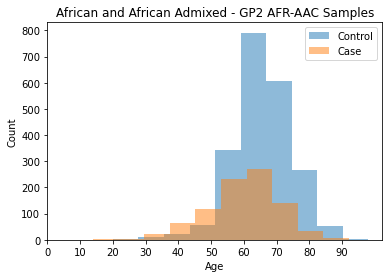

In [217]:
fig = plot_age_distribution_bars(final_cov_age, 'PHENO', 'AGE_ANALYSIS', "African and African Admixed - GP2 AFR-AAC Samples")

In [ ]:
## Read in Nigerian NC covariates 
nigerian_nc = pd.read_csv(f"{WORK_DIR}/data/AFR/NIGERIAN-NC/NIGERIAN-NEUROCHIP-AFR-covariate-FEB2023.txt", sep="\t")
nigerian_nc

In [219]:
nc_cases_ages = ages_raw[ages_raw['PHENO']==2]
print(nc_cases_ages.shape)
missingness_percentage(nc_cases_ages)

(1317, 6)


,Column,Percent_Missing
0,AADx,94.988610
1,AAO,6.757783
2,AGE,2.657555
3,IID,0.000000
4,PHENO,0.000000
5,SEX,0.000000


In [220]:
nc_controls_ages = ages_raw[ages_raw['PHENO']==1]
print(nc_controls_ages.shape)
missingness_percentage(nc_controls_ages)

(2619, 6)


,Column,Percent_Missing
0,AAO,97.327224
1,AADx,97.327224
2,AGE,1.641848
3,IID,0.000000
4,PHENO,0.000000
5,SEX,0.000000


In [221]:
# Prioritize AAO then age at recruitment 
ages_raw['AGE_ANALYSIS'] = ages_raw['AAO'].fillna(ages_raw['AGE'])

In [222]:
nc_cases_ages = ages_raw[ages_raw['PHENO']==2]
print(nc_cases_ages.shape)
missingness_percentage(nc_cases_ages)

(1317, 7)


,Column,Percent_Missing
0,AADx,94.988610
1,AAO,6.757783
2,AGE,2.657555
3,AGE_ANALYSIS,2.657555
4,IID,0.000000
5,PHENO,0.000000
6,SEX,0.000000


In [ ]:
## Drop some columns so they dont give us an issue during merging 
ages_raw.drop(columns=['PHENO','SEX'], inplace=True)

## Imputing age information 
ages_raw['AGE_ANALYSIS'] = ages_raw['AGE_ANALYSIS'].fillna(ages_raw['AGE_ANALYSIS'].mean())

ng_nc_final_cov_age = pd.merge(nigerian_nc, ages_raw, how="left", on="IID")
ng_nc_final_cov_age.to_csv(f"{WORK_DIR}/data/AFR/NIGERIAN-NC/NIGERIAN-NEUROCHIP-AFR-covariate-wAGE-FEB2023.txt", index=False, sep="\t", na_rep=np.nan)
ng_nc_final_cov_age

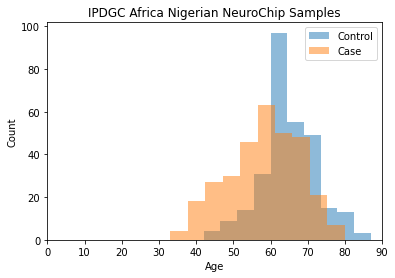

In [224]:
fig2 = plot_age_distribution_bars(ng_nc_final_cov_age, 'PHENO', 'AGE_ANALYSIS', "IPDGC Africa Nigerian NeuroChip Samples")

# Prepping chr1 EUR from GP2 release 4

In [ ]:
%%bash

## Make PLINK v1.9 files 

plink2 --pfile ${WORK_DIR}/data/other/GP2_v4_EUR_chr1/chr1_EUR_release4 \
--make-bed --out ${WORK_DIR}/data/other/GP2_v4_EUR_chr1/chr1_EUR_release4_noSEXPHENO 

In [245]:
## Read in files 
master_key = pd.read_csv(f"{WORK_DIR}/data/other/GP2_v4_EUR_chr1/master_key_release4_final.csv", usecols=['GP2sampleID', 'sex_for_qc', 'pheno_for_qc'])
eur_pcs = pd.read_csv(f"{WORK_DIR}/data/other/GP2_v4_EUR_chr1/GP2_round4_JAN_24_2023_EUR_maf_hwe_pca.eigenvec", sep="\t")
eur_v4_fam = pd.read_csv(f"{WORK_DIR}/data/other/GP2_v4_EUR_chr1/chr1_EUR_release4_noSEXPHENO.fam", sep="\t", header=None)
eur_v4_fam.columns = ['FID', 'IID', 'PAT', 'MAT', 'SEX', 'PHENO']
eur_v4_fam.drop(columns=['PAT', 'MAT', 'SEX', 'PHENO'], inplace=True)

## Add FID and IID to match PLINK1.9 convention
master_key['FID'] = 0
#master_key['IID'] = master_key['FID'].astype(str) + '_' + master_key['GP2sampleID'].astype(str)
master_key['IID'] = master_key['GP2sampleID'].astype(str)
master_key.drop(columns=['FID','GP2sampleID'], inplace=True)

## Keep samples that only have a 1 or 2 for PHENO
master_key = master_key[master_key['pheno_for_qc'] >= 1]
master_key.rename(columns={'sex_for_qc':'SEX', 'pheno_for_qc':'PHENO'}, inplace=True)

## Format European PCs
eur_pcs.drop(columns=['#FID'], inplace=True)

## Merge 
merge_fam_pcs = pd.merge(eur_v4_fam, eur_pcs, how="left", on="IID")
merge_df = pd.merge(merge_fam_pcs, master_key, how="left", on="IID")

rearrange_merge_df = merge_df[['FID', 'IID', 'SEX', 'PHENO', 'PC1', 'PC2', 'PC3', 'PC4', 'PC5', 'PC6', 'PC7', 'PC8', 'PC9', 'PC10']].copy()
rearrange_merge_df['SEX']=[int(val) if isinstance(val,numbers.Number) & (math.isnan(val)==False) else -9 for val in rearrange_merge_df['SEX']]
rearrange_merge_df['PHENO']=[int(val) if isinstance(val,numbers.Number) & (math.isnan(val)==False) else 0 for val in rearrange_merge_df['PHENO']]
rearrange_merge_df = rearrange_merge_df[rearrange_merge_df['PHENO'] >= 1]

# Save
rearrange_merge_df.to_csv(f"{WORK_DIR}/data/other/GP2_v4_EUR_chr1/GP2_v4_EUR_updated_covariateFile_FEB2023.txt", index=False, sep="\t", na_rep=np.nan)

# Make update files for PLINK
update_sex = rearrange_merge_df[['FID', 'IID', 'SEX']]
update_sex.to_csv(f"{WORK_DIR}/data/other/GP2_v4_EUR_chr1/GP2_v4_EUR_updateSEX_FEB2023.txt", index=False, header=None, sep="\t")

update_pheno = rearrange_merge_df[['FID', 'IID', 'PHENO']]
update_pheno.to_csv(f"{WORK_DIR}/data/other/GP2_v4_EUR_chr1/GP2_v4_EUR_updatePHENO_FEB2023.txt", index=False, header=None, sep="\t")

In [ ]:
%%bash

## Update sex and phenotype 

plink --bfile ${WORK_DIR}/data/other/GP2_v4_EUR_chr1/chr1_EUR_release4_noSEXPHENO \
--pheno ${WORK_DIR}/data/other/GP2_v4_EUR_chr1/GP2_v4_EUR_updatePHENO_FEB2023.txt \
--update-sex ${WORK_DIR}/data/other/GP2_v4_EUR_chr1/GP2_v4_EUR_updateSEX_FEB2023.txt \
--make-bed --out ${WORK_DIR}/data/other/GP2_v4_EUR_chr1/chr1_EUR_release4

## kept 7952 cases and 4326 controls

## Splitting age to plot

In [7]:
final_cov_age = pd.read_csv(f"{WORK_DIR}/data/masterfile_updated_GP2_v4_covariateFile_wAGE_FEB2023.txt", sep="\t")
final_cov_age_AFR = final_cov_age[final_cov_age['LABEL']=="AFR"].copy()
final_cov_age_AAC = final_cov_age[final_cov_age['LABEL']=="AAC"].copy()

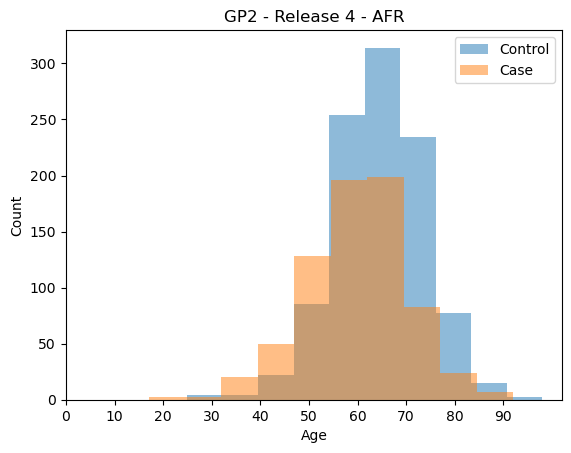

In [10]:
fig = plot_age_distribution_bars(final_cov_age_AFR, 'PHENO', 'AGE_ANALYSIS', "GP2 - Release 4 - AFR")

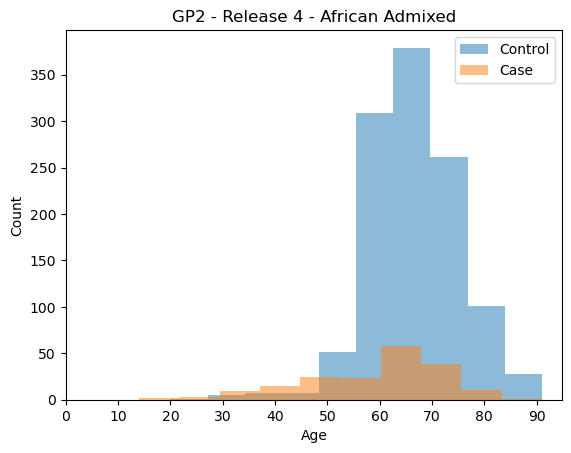

In [12]:
fig = plot_age_distribution_bars(final_cov_age_AAC, 'PHENO', 'AGE_ANALYSIS', "GP2 - Release 4 - African Admixed")